<a href="https://colab.research.google.com/github/Tobsam237/Springboard_Project_Capstone2/blob/main/Springboard_Project_Capstone2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install sodapy

In [3]:
#importing data via api 

#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("h9gi-nx95", limit=10000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [4]:
#view database and it's shape
print(results_df.shape)
results_df.sample(5)

(10000, 29)


,crash_date,crash_time,on_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,collision_id,vehicle_type_code1,contributing_factor_vehicle_2,vehicle_type_code2,latitude,longitude,location,cross_street_name,off_street_name,borough,zip_code,contributing_factor_vehicle_3,vehicle_type_code_3,contributing_factor_vehicle_4,vehicle_type_code_4,contributing_factor_vehicle_5,vehicle_type_code_5
8284,2020-12-14T00:00:00.000,12:05,1 AVENUE,1,0,1,0,0,0,0,0,Driver Inattention/Distraction,4376008,Station Wagon/Sport Utility Vehicle,NaN,NaN,40.7723400,-73.9526900,"{'latitude': '40.77234', 'longitude': '-73.952...",NaN,EAST 79 STREET,MANHATTAN,10075,NaN,NaN,NaN,NaN,NaN,NaN
6276,2021-01-09T00:00:00.000,23:51,EAST 110 STREET,0,0,0,0,0,0,0,0,Unspecified,4383114,Sedan,Unspecified,Sedan,40.7948070,-73.9444100,"{'latitude': '40.794807', 'longitude': '-73.94...",NaN,LEXINGTON AVENUE,MANHATTAN,10029,Unspecified,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
5414,2021-01-31T00:00:00.000,16:00,NaN,0,0,0,0,0,0,0,0,Other Vehicular,4388232,Station Wagon/Sport Utility Vehicle,Unspecified,Sedan,40.8322450,-73.8886900,"{'latitude': '40.832245', 'longitude': '-73.88...",1471 VYSE AVENUE,NaN,BRONX,10460,NaN,NaN,NaN,NaN,NaN,NaN
9026,2020-12-16T00:00:00.000,1:15,9 AVENUE,1,0,0,0,0,0,1,0,Turning Improperly,4376476,Sedan,Unspecified,Sprinter V,40.7584270,-73.9926400,"{'latitude': '40.758427', 'longitude': '-73.99...",NaN,WEST 42 STREET,MANHATTAN,10036,NaN,NaN,NaN,NaN,NaN,NaN
2274,2021-01-16T00:00:00.000,19:25,SAINT NICHOLAS AVENUE,0,0,0,0,0,0,0,0,Alcohol Involvement,4384674,Station Wagon/Sport Utility Vehicle,Unspecified,Station Wagon/Sport Utility Vehicle,40.8240300,-73.9447600,"{'latitude': '40.82403', 'longitude': '-73.944...",NaN,WEST 145 STREET,MANHATTAN,10030,NaN,NaN,NaN,NaN,NaN,NaN


Data Wrangling

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
results_df.describe()

,crash_date,crash_time,on_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,collision_id,vehicle_type_code1,contributing_factor_vehicle_2,vehicle_type_code2,latitude,longitude,location,cross_street_name,off_street_name,borough,zip_code,contributing_factor_vehicle_3,vehicle_type_code_3,contributing_factor_vehicle_4,vehicle_type_code_4,contributing_factor_vehicle_5,vehicle_type_code_5
count,10000,10000,7382,10000,10000,10000,10000,10000,10000,10000,10000,9926,10000,9867,7457,6405,9005,9005,9005,2616,4591,6370,6369,1042,975,282,269,82,81
unique,182,1295,1828,11,2,4,2,3,2,11,2,48,10000,91,32,98,7261,6904,7637,2550,1905,5,176,11,27,5,12,3,4
top,2020-12-04T00:00:00.000,0:00,BELT PARKWAY,0,0,0,0,0,0,0,0,Unspecified,4380772,Sedan,Unspecified,Sedan,40.8618620,-73.9128200,"{'latitude': '40.861862', 'longitude': '-73.91...",815 HUTCHINSON RIVER PARKWAY,3 AVENUE,BROOKLYN,11207,Unspecified,Sedan,Unspecified,Sedan,Unspecified,Sedan
freq,226,165,176,7032,9980,9361,9993,9630,9995,8026,9992,2734,1,4847,6463,2910,9,9,8,4,37,2246,181,978,491,268,145,78,40


Lets go ahead and clean 

In [7]:
#observe null values by columns
results_df.isna().sum()

crash_date                          0
crash_time                          0
on_street_name                   2618
number_of_persons_injured           0
number_of_persons_killed            0
number_of_pedestrians_injured       0
number_of_pedestrians_killed        0
number_of_cyclist_injured           0
number_of_cyclist_killed            0
number_of_motorist_injured          0
number_of_motorist_killed           0
contributing_factor_vehicle_1      74
collision_id                        0
vehicle_type_code1                133
contributing_factor_vehicle_2    2543
vehicle_type_code2               3595
latitude                          995
longitude                         995
location                          995
cross_street_name                7384
off_street_name                  5409
borough                          3630
zip_code                         3631
contributing_factor_vehicle_3    8958
vehicle_type_code_3              9025
contributing_factor_vehicle_4    9718
vehicle_type

In [8]:
#drop irrevlevant columns with high Null values
results_df.drop([ 'location', 'on_street_name', 'contributing_factor_vehicle_2',
       'vehicle_type_code2', 'contributing_factor_vehicle_3',
       'vehicle_type_code_3', 'off_street_name',
       'cross_street_name', 'contributing_factor_vehicle_4',
       'contributing_factor_vehicle_5', 'vehicle_type_code_4',
       'vehicle_type_code_5'], axis = 1, inplace = True )

dropped all columns with over  50% NAs: 

In [9]:
results_df.sample(3)

,crash_date,crash_time,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,collision_id,vehicle_type_code1,latitude,longitude,borough,zip_code
4630,2020-12-09T00:00:00.000,14:00,1,0,0,0,1,0,0,0,Failure to Yield Right-of-Way,4375084,Sedan,40.6629400,-73.8755800,BROOKLYN,11208
5061,2020-12-15T00:00:00.000,13:40,0,0,0,0,0,0,0,0,Passing or Lane Usage Improper,4376550,Station Wagon/Sport Utility Vehicle,40.7832260,-73.8386200,QUEENS,11356
2829,2021-01-05T00:00:00.000,19:15,0,0,0,0,0,0,0,0,Backing Unsafely,4381952,Sedan,40.8574180,-73.8999560,BRONX,10468


In [10]:
#check for null values again
print(results_df.shape)
results_df.isna().sum()

#we can obtain borough and zip columns from d lonitude and latitude columns

(10000, 17)


crash_date                          0
crash_time                          0
number_of_persons_injured           0
number_of_persons_killed            0
number_of_pedestrians_injured       0
number_of_pedestrians_killed        0
number_of_cyclist_injured           0
number_of_cyclist_killed            0
number_of_motorist_injured          0
number_of_motorist_killed           0
contributing_factor_vehicle_1      74
collision_id                        0
vehicle_type_code1                133
latitude                          995
longitude                         995
borough                          3630
zip_code                         3631
dtype: int64

In [11]:
#drop lat and longitude colunmns with Null values
df = results_df[~results_df['longitude'].isna()]
df.isna().sum()

crash_date                          0
crash_time                          0
number_of_persons_injured           0
number_of_persons_killed            0
number_of_pedestrians_injured       0
number_of_pedestrians_killed        0
number_of_cyclist_injured           0
number_of_cyclist_killed            0
number_of_motorist_injured          0
number_of_motorist_killed           0
contributing_factor_vehicle_1      67
collision_id                        0
vehicle_type_code1                123
latitude                            0
longitude                           0
borough                          2856
zip_code                         2857
dtype: int64

In [12]:
#observe we still have some null values on borough and zip_codes, lets isolate them

df_pre = df[df['zip_code'].isna()]
df_dim = df_pre[['latitude', 'longitude', 'zip_code', 'borough']]
df_dim.dtypes

latitude     object
longitude    object
zip_code     object
borough      object
dtype: object

In [13]:
#convert latitude, longitude to correct dtypes

df_dim[['latitude', 'longitude', 'zip_code']] = df_pre[['latitude', 'longitude', 'zip_code']].astype(float)
df_dim.dtypes

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


latitude     float64
longitude    float64
zip_code     float64
borough       object
dtype: object

In [14]:
#In order to obtain missing zipcodes and borough columns from the latitude and longitude, we use the uszipcode package
!pip install uszipcode

     |████████████████████████████████| 378kB 6.6MB/s 
     |████████████████████████████████| 81kB 5.9MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
     |████████████████████████████████| 51kB 3.8MB/s 


In [15]:
import pandas as pd
import numpy as np
import time
from uszipcode import SearchEngine


In [16]:
#quick glance at an isolated dataframe of longitude, latitude and the missing zipcode and borough
df_dim.head()

,latitude,longitude,zip_code,borough
2,40.697815,-73.76020,NaN,NaN
17,40.724667,-73.82076,NaN,NaN
26,40.866447,-73.93050,NaN,NaN
32,40.657093,-73.95026,NaN,NaN
47,40.665730,-73.75376,NaN,NaN


In [17]:
#loop through to obtain the missing zip and borough
search = SearchEngine()
pdf = df_dim

tic = time.time()
for idx in pdf.iloc[:,:].index:
    try:
        pdf['zip_code'][idx] = search.by_coordinates(
                    pdf['latitude'][idx], pdf['longitude'][idx], 
                    returns=1)[0].to_dict()["zipcode"]
                    
    except:
        pdf['zip_code'][idx] = 'bad'

    try:
        pdf['borough'][idx] = search.by_coordinates(
                    pdf['latitude'][idx], pdf['longitude'][idx], 
                    returns=1)[0].to_dict()["county"]
                    
    except:
        pdf['borough'][idx] = 'bad'
toc = time.time()
toc - tic

Start downloading data for simple zipcode database, total size 9MB ...
  1 MB finished ...
  2 MB finished ...
  3 MB finished ...
  4 MB finished ...
  5 MB finished ...
  6 MB finished ...
  7 MB finished ...
  8 MB finished ...
  9 MB finished ...
  10 MB finished ...
  Complete!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


119.21937656402588

In [18]:
print(df.shape)
print(pdf.shape)

(9005, 17)
(2857, 4)


In [19]:
#let's update df
df.update(pdf)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [20]:
#but note there still some mess in df... 
#'bad, "county vs bourough", "other NAs"
#drop remaining NAs
df2 = df.dropna()

In [21]:
#drop failed, where it yielded 'bad' zip_code and borough
df2 = df2[~(df2['zip_code']== 'bad')]

In [22]:
#Note that county and bourough are diff... we need the borough not county
print(df2['borough'].unique())

['Queens County' 'New York County' 'MANHATTAN' 'QUEENS' 'STATEN ISLAND'
 'Kings County' 'BROOKLYN' 'BRONX' 'Bronx County' 'Richmond County'
 'Westchester County' 'Nassau County']


In [23]:
#Bergen county is in New Jersey, so drop
df3 = df2[~(df2['borough'] == 'Bergen County')]

In [24]:
df3.replace({'borough': dict.fromkeys(['Queens County', 'Nassau County', 'Richmond County'], 'QUEENS')}, inplace = True)
df3.replace({'borough': dict.fromkeys(['Bronx County', 'Westchester County'], 'BRONX')}, inplace= True)
df3.replace({ 'borough': {'Kings County': 'BROOKLYN', 'New York County':  'MANHATTAN'}}, inplace= True)

df3['borough'].unique()

array(['QUEENS', 'MANHATTAN', 'STATEN ISLAND', 'BROOKLYN', 'BRONX'],
      dtype=object)

In [25]:
df3.head()

,crash_date,crash_time,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,collision_id,vehicle_type_code1,latitude,longitude,borough,zip_code
2,2021-02-01T00:00:00.000,15:30,0,0,0,0,0,0,0,0,Unspecified,4388639,Sedan,40.6978,-73.7602,QUEENS,11412
26,2021-01-19T00:00:00.000,14:40,0,0,0,0,0,0,0,0,Following Too Closely,4385331,Sedan,40.8664,-73.9305,MANHATTAN,10034
28,2021-01-19T00:00:00.000,8:22,1,0,1,0,0,0,0,0,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,4385270,Bike,40.7747080,-73.9746900,MANHATTAN,10000
29,2021-01-19T00:00:00.000,9:20,0,0,0,0,0,0,0,0,Backing Unsafely,4385175,Sedan,40.7610470,-73.8351800,QUEENS,11354
31,2021-01-16T00:00:00.000,9:00,0,0,0,0,0,0,0,0,Unsafe Speed,4384644,Sedan,40.6103400,-74.0734940,STATEN ISLAND,10305


In [26]:
#check for duplicates
print(df3.duplicated().sum())
print(df3.collision_id.duplicated().sum())

0
0


In [27]:
df3.describe().T

,count,unique,top,freq
crash_date,8869,124,2020-12-11T00:00:00.000,200
crash_time,8869,1259,0:00,148
number_of_persons_injured,8869,10,0,6299
number_of_persons_killed,8869,2,0,8856
number_of_pedestrians_injured,8869,3,0,8368
number_of_pedestrians_killed,8869,2,0,8863
number_of_cyclist_injured,8869,3,0,8527
number_of_cyclist_killed,8869,2,0,8867
number_of_motorist_injured,8869,10,0,7127
number_of_motorist_killed,8869,2,0,8864


In [28]:
#observe that all columns have an object datatype
df3.dtypes

crash_date                       object
crash_time                       object
number_of_persons_injured        object
number_of_persons_killed         object
number_of_pedestrians_injured    object
number_of_pedestrians_killed     object
number_of_cyclist_injured        object
number_of_cyclist_killed         object
number_of_motorist_injured       object
number_of_motorist_killed        object
contributing_factor_vehicle_1    object
collision_id                     object
vehicle_type_code1               object
latitude                         object
longitude                        object
borough                          object
zip_code                         object
dtype: object

In [29]:
df3['crash_date'] = pd.to_datetime(df3['crash_date']).dt.date
df3['crash_time'] = pd.to_datetime(df3['crash_time']).dt.time

In [30]:
print(df3.shape)
print(df3.columns)
df3.dtypes

(8869, 17)
Index(['crash_date', 'crash_time', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'contributing_factor_vehicle_1',
       'collision_id', 'vehicle_type_code1', 'latitude', 'longitude',
       'borough', 'zip_code'],
      dtype='object')


crash_date                       object
crash_time                       object
number_of_persons_injured        object
number_of_persons_killed         object
number_of_pedestrians_injured    object
number_of_pedestrians_killed     object
number_of_cyclist_injured        object
number_of_cyclist_killed         object
number_of_motorist_injured       object
number_of_motorist_killed        object
contributing_factor_vehicle_1    object
collision_id                     object
vehicle_type_code1               object
latitude                         object
longitude                        object
borough                          object
zip_code                         object
dtype: object

In [31]:
num_columns = ['number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'latitude',
       'longitude']
dt_columns = ['crash_date', 'crash_time']
cat_columns = ['contributing_factor_vehicle_1',
       'collision_id', 'vehicle_type_code1',
       'borough', 'zip_code']

In [32]:
df3[num_columns]= df3[num_columns].astype(float)
df3[cat_columns] = df3[cat_columns].astype('category')

In [33]:
df3.dtypes

crash_date                         object
crash_time                         object
number_of_persons_injured         float64
number_of_persons_killed          float64
number_of_pedestrians_injured     float64
number_of_pedestrians_killed      float64
number_of_cyclist_injured         float64
number_of_cyclist_killed          float64
number_of_motorist_injured        float64
number_of_motorist_killed         float64
contributing_factor_vehicle_1    category
collision_id                     category
vehicle_type_code1               category
latitude                          float64
longitude                         float64
borough                          category
zip_code                         category
dtype: object

In [34]:
dff = df3.reset_index()
dff.shape

(8869, 18)

In [35]:
dff.head()

,index,crash_date,crash_time,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,contributing_factor_vehicle_1,collision_id,vehicle_type_code1,latitude,longitude,borough,zip_code
0,2,2021-02-01,15:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Unspecified,4388639,Sedan,40.697815,-73.760200,QUEENS,11412
1,26,2021-01-19,14:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Following Too Closely,4385331,Sedan,40.866447,-73.930500,MANHATTAN,10034
2,28,2021-01-19,08:22:00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,4385270,Bike,40.774708,-73.974690,MANHATTAN,10000
3,29,2021-01-19,09:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Backing Unsafely,4385175,Sedan,40.761047,-73.835180,QUEENS,11354
4,31,2021-01-16,09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Unsafe Speed,4384644,Sedan,40.610340,-74.073494,STATEN ISLAND,10305


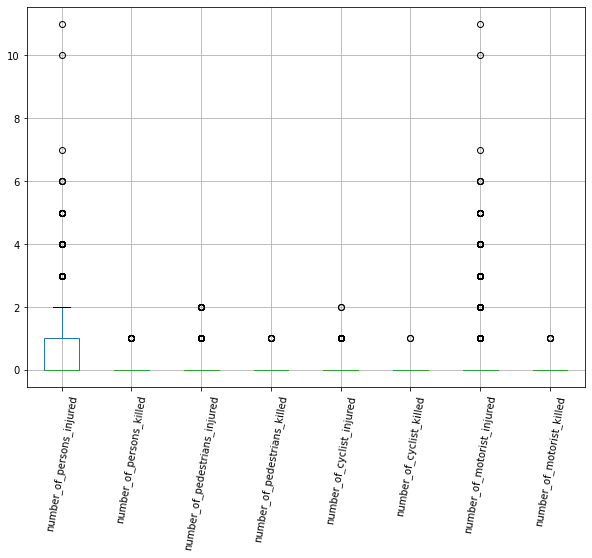

In [36]:
#range of people killed or injured seems true, thus no outliers from below plot
dff.boxplot(column= ['number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed'], rot = 80, figsize=(10,7))
plt.show()

In [37]:
dff['contributing_factor_vehicle_1'].unique()

['Unspecified', 'Following Too Closely', 'Pedestrian/Bicyclist/Other Pedestrian Error/C..., 'Backing Unsafely', 'Unsafe Speed', ..., 'Headlights Defective', 'Traffic Control Device Improper/Non-Working', 'Other Electronic Device', 'Tow Hitch Defective', 'Shoulders Defective/Improper']
Length: 48
Categories (48, object): ['Unspecified', 'Following Too Closely',
                          'Pedestrian/Bicyclist/Other Pedestrian Error/C..., 'Backing Unsafely', ...,
                          'Traffic Control Device Improper/Non-Working', 'Other Electronic Device', 'Tow Hitch Defective',
                          'Shoulders Defective/Improper']

In [38]:
print(dff[ 'vehicle_type_code1'].unique())

['Sedan', 'Bike', 'Bus', 'Flat Bed', 'Station Wagon/Sport Utility Vehicle', ..., 'util', 'Unk', 'MARKED VAN', 'SANITATION', 'SNOW PLOW']
Length: 83
Categories (83, object): ['Sedan', 'Bike', 'Bus', 'Flat Bed', ..., 'Unk', 'MARKED VAN', 'SANITATION',
                          'SNOW PLOW']
